<a href="https://colab.research.google.com/github/merveenoyan/example_notebooks/blob/main/SAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Segment Anything Model (SAM) in TensorFlow

Segment Anything Model (SAM) is the first image-segmentation capable of doing zero-shot segmentation with a prompt input, inspired by large language models. The prompt here can be a set of foreground/background points, free text, a box or a mask. There are many downstream segmentation tasks, including semantic segmentation and edge detection. The goal of SAM is to enable all of these downstream segmentation tasks through prompting.

## Inference
First we will install transformers from main to make sure we have the latest version that has `TFSamModel`.

In [ ]:
!pip install git+https://github.com/huggingface/transformers

### Loading the model
There's three checkpoints for SAM model, [sam-vit-base](https://huggingface.co/facebook/sam-vit-base), [sam-vit-large](https://huggingface.co/facebook/sam-vit-large) and [sam-vit-huge](https://huggingface.co/facebook/sam-vit-huge). We will load `sam-vit-base` in `TFSamModel`. We also need `SamProcessor`for the associated checkpoint.

In [ ]:
from transformers import TFSamModel, SamProcessor

model = TFSamModel.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

All model checkpoint layers were used when initializing TFSamModel.

All the layers of TFSamModel were initialized from the model checkpoint at facebook/sam-vit-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFSamModel for predictions without further training.


We will segment a car image using a point prompt. Make sure to set `return_tensors` to `tf` when calling the processor. 

In [ ]:
from PIL import Image
import requests

img_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
raw_image = Image.open(requests.get(img_url, stream=True).raw).convert("RGB")
# this is going to be our prompt
input_points = [[[450, 600]]]

inputs = processor(raw_image, input_points=input_points, return_tensors="tf")
outputs = model(**inputs)

We can get evaluate the output by first post processing the output mask and then get Intersection over Union (IoU) like below. 

In [ ]:
import numpy as np
masks = processor.image_processor.post_process_masks(outputs.pred_masks, inputs["original_sizes"], 
                                                     inputs["reshaped_input_sizes"], return_tensors="tf")
scores = outputs.iou_scores

In [ ]:
masks[0].shape

TensorShape([1, 3, 1764, 2646])

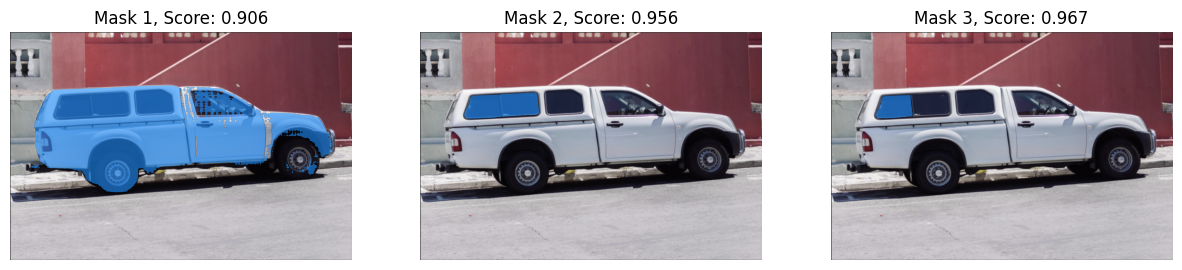

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.ops.numpy_ops import np_config

np_config.enable_numpy_behavior()

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

def show_masks_on_image(raw_image, masks, scores):
    if len(masks[0].shape) == 4:
      final_masks = tf.squeeze(masks[0])
    if scores.shape[0] == 1:
      final_scores = tf.squeeze(scores)

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(final_masks, final_scores)):
      mask = tf.stop_gradient(mask)
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.numpy().item():.3f}")
      axes[i].axis("off")
    plt.show()

show_masks_on_image(raw_image, masks, scores)

`transformers` `pipeline` is a high level API that abstracts away the above process for us. You can simply initialize `mask-generation` pipeline with the SAM model checkpoint if your choice. By default, it uses `sam-vit-huge`. We can simply pass our image and `points_per_batch` --the number of input points to process simultaneously in one batch--. Higher `points_per_batch` results in improvements in speed but higher GPU memory consumption.

In [ ]:
from transformers import pipeline
generator =  pipeline("mask-generation", model ="facebook/sam-vit-base",  points_per_batch = 64)
image_url = "https://huggingface.co/ybelkada/segment-anything/resolve/main/assets/car.png"
outputs = generator(image_url, points_per_batch = 64)